<a href="https://colab.research.google.com/github/rlagp12/BIO165_final-project/blob/main/THEsolution_BIO165_W8_drylab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 8 Dry Lab: 'omics

### Logistics

#### Jupyter notebooks

We will use Jupyter based notebooks like this to run the dry labs. The notebooks will guide you through the dry labs each week, containing some markdown cells with some background information, <font color=orange> exercises</font>, and example or skeleton code for exercises.

In this class, data and code will be made available through Canvas. All of the homework submissions will be individual but we still highly encourage you to work in teams. For each homework submission you'll be asked to submit your code (this Jupyter workbook once you have worked through it) as a PDF via Gradescope. To save a pdf version of your notebook in VSCode, click on the three dots next to outline in VSCode, choose "export" and then choose the pdf option. Alternatively, choose export and then the HTML option, open the html file (in your browser), click print with the destination "save as a PDF". Please submit your pdf on gradescope and indicate location of your answer for each question. Homework is due **<font color=lightblue> on Thursday 03/06/2025 at 11:59 pm</font>**.



### This week

This week, we will dive into analyzing an RNA-Seq database from Jackson et al (eLife, 2020) using the tools we've discussed this week in class.

We will cover the following topics:

1. Considering noise in omics data using bulk RNA-seq data
2. Checking for noise in single-cell RNA-Seq data using a pseudobulk analysis
3. Visualizing single-cell RNA-Seq data using PCA and UMAP
4. Clustering sub-populations of cells from single-cell RNA-Seq data
4. Simple gene networks and protein oscillations

To complete this lab you will need:

1. This Jupyter notebook
2. A Python IDE (you can use Anaconda, Visual Studio, or PyCharm), which you already set up before
3. bulk RNA-Seq data from Jackson et al, (`YPD_bulk.tsv`)
4. single-cell RNA-Seq data from Jackson et al (`jackson_data_YPD_proline_CStarve.tsv`)
5. gene group labels, (`gene_groups.tsv`)


In [16]:
# run this if you have not installed pyDESeq2 or umap-learn
!pip install pyDESeq2
!pip install umap-learn

In [17]:
# the first step for most code

# import libraries

# standard libraries
import os
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt

# differential expression
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

# dimentionality reduction and clustering
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import umap
# Anaconda should automatically install all of these libraries, but if this does not work you might not
# have these libraries installed. If this is the case, you can install them using pip install.

In this lab we'll analyze datasets generated in Jackson et al. There are two datasets we'll use: one of bulk RNA sequencing of *S. cerevisiae* in YPD (rich media), and another of single cell RNAseq data of the same strain in several environmental conditions (including YPD). We'll begin by considering the level of noise in the data.

## Noise in Sequencing Data

In class we discussed that intuitively transcripts with fewer reads are going to be more noisy. In this exercise we'll think about this a bit more by looking at the variation across replicates of the bulk data, and comparing this to a simulation.

The number of reads per transcript ($X$) is often approximated as a Poisson random variable, with scaling factor $\lambda = np$ where $n$ is the total number of reads and $p$ is the frequency of the transcript in the pool; $X \sim Pois(np)$. Let's start by testing whether the bulk data matches properties of the Poisson distributed noise.

Below you'll find code to import the bulk dataset.

<font color = 'orange'>

<b> Exercise 1 (15 points) </b>


1.1 [4 points] Make two plots (or a figure with two subplots): (i) Plot the variance of the frequency of each transcript across samples against the mean frequency across samples, and (ii) plot the coefficient of variation agains the mean frequency. In class we discussed that lower reads have the higher noise. Explain how both of these plots show that this intuition is true. Hint: Consider whether we're considering absolute noise or relative noise.

Let's consider the process of counting reads as a stochastic process. When sequencing, the total number of DNA fragements in a flow cell is much larger than the ones that are actually read (and aligned, passed through QC etc). So, we can model this as picking sequences randomly (with replacement) from the total DNA fragements in the flow cell. As we discussed in class, for each draw we can model this as a Bernoulli trial (flipping an unfair coin), where the probability of getting a transcript with frequency $f_i$ is $f_i$. To model repeating this trail several times, we can model the number of counts corresponding to each transcript as a binomial distribution:

$$ P(X_i = k) = {n \choose k} f_i^k (1-f_i)^{n-k} $$

1.2 [3 points] Let's now compare the results of simulating our model against data. You'll find code that simulates counting reads as a multinomial using parameters extracted from the data. The output of this simulation is a 2D-array where rows represent samples and columns represent genes. Make analogous plots to those from 1.1, now with the simulated data.

1.3 [2 points] Let's consider one transcript $i$ with frequency $f_i$ and read count $X_i$. The mean of the binomial distribution (expected number of reads) is $nf_i$, and the variance is $nf_i(1-f_i)$. The frequency of any given transcript is small. Under this approximation, what is the variance of $X_i$? How do you expect it to scale with the mean?  

1.4 [2 points] Under this approximation, what is the relationship between variance and mean number of reads? What about coefficient of variation? Plot this as a dashed line on top of the plots you generated in 1.1 and 1.2.

1.5 [2 points] Mention one way in which the results from the data match the expectation from the simulation, and one way in which they differ.

1.6 [2 points] Based on your answers to previous questions, do you think that the underlying process generating noise in the data is from a binomial (or Poisson) process? If not, where in the sequencing process do you think deviations in the noise could come from?

<font color = 'lightblue'>

Note that there is some inconsistency in these questions together: 1.1 and 1.2 ask students to consider transcript frequency, whereas 1.3 and 1.4 ask students to consider transcript counts. To deal with this, we'll allow students to consider either of them, but will require that for 1.4 they plot a line that matches the plot they made in 1.1/1.2.  

1.1: see code below. Also give equal credit for students who plot transcript counts.

1.2: see code below.

1.3 When $f_i$ is small, the variance of the number of counts, precisely $nf_i(1-f_i)$, is approximately $nf_i$, because $(1-f_i)$ is approximately 1 in this case. The mean is $nf_i$, so when $f_i$ is small, variance is approximately the mean.

1.4 For counts: variance is $nf_i$, and cofficient of variation is $\frac{\sqrt{nf_i}}{nf_i} = \frac{1}{\sqrt{nf_i}}$.

For frequency: Let's denote measured frequency $\frac{X_i}{n}$ by $\rho_i$. $Var(\rho_i) = Var(\frac{X_i}{n}) = \frac{1}{n^2}Var(X_i) = \frac{1}{n^2}nf_i = \frac{f_i}{n}$. Coefficient of variation is $\frac{\sqrt{Var(\rho_i)}}{E(\rho_i)} = \sqrt{\frac{f_i}{n}} \frac{1}{f_i} = \frac{1}{\sqrt{nf_i}}$.

See code below for plotting.

1.5 The general trends - variance increasing and coefficient of variation decreasing with mean counts/frequency - are the same between simulations and the data, but variance and coefficient of variation is higher than expected from the simulations, especially for low frequency counts.

1.6 There's more noise than expected from the simulations, suggesting that there's more noise in the process than a simple counting process. This could be due to noise introduced from any numebr of steps; this could be from "jackpotting" noise in PCR amplification, systematic differences between transcripts etc.

In [21]:
# bulk data

bulk_data = pd.read_csv("/content/karim_etal_data.csv", sep=',',index_col = 0).T
bulk_data

Geneid,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000237613,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000239945,...,ENSG00000273532,ENSG00000276351,ENSG00000275661,ENSG00000277856,ENSG00000275063,ENSG00000271254,ENSG00000275405,ENSG00000275987,ENSG00000277475,ENSG00000268674
1,0,41,0,3,0,0,0,0,0,0,...,0,0,0,0,0,249,0,0,3,0
2,0,66,0,2,0,0,0,0,0,0,...,0,0,0,0,0,372,0,1,0,0
3,0,63,0,0,0,0,0,0,0,0,...,0,0,0,0,0,221,0,0,0,0
4,0,37,0,3,0,0,0,0,0,0,...,0,0,0,0,0,274,0,1,0,0
5,0,39,0,0,0,0,0,0,0,0,...,0,0,0,0,0,232,0,0,0,0
6,0,50,0,0,0,0,1,0,0,0,...,0,0,0,0,0,235,0,0,0,0
7,0,52,4,0,0,0,0,0,0,0,...,0,0,0,0,0,259,0,0,0,0
8,0,51,0,0,0,0,0,0,0,0,...,0,0,0,0,0,237,0,0,0,0
9,0,34,1,1,0,0,0,0,0,0,...,0,0,0,0,0,130,0,0,1,0
10,0,41,2,0,0,0,0,0,0,0,...,0,0,0,0,0,114,0,0,0,0


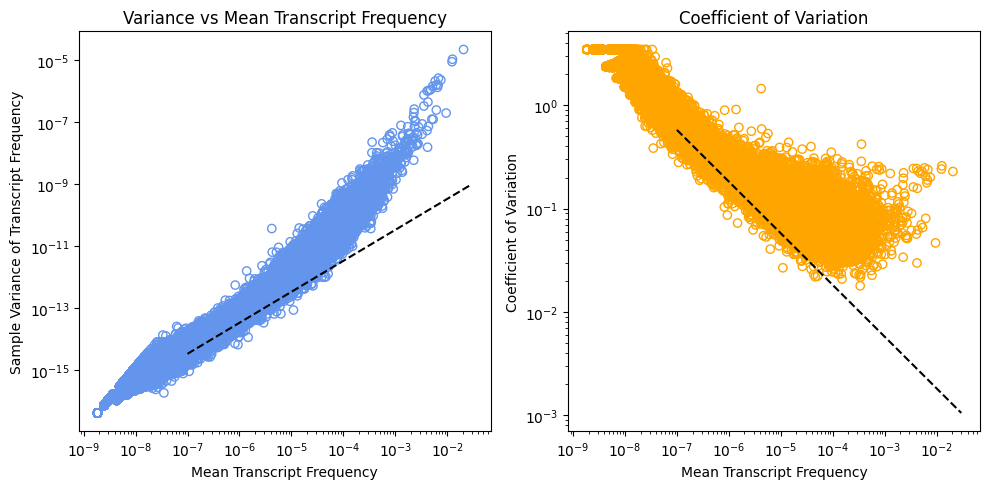

In [22]:
# SOLUTION
bulk_data_normalized = bulk_data.div(bulk_data.sum(axis=1), axis=0)
bulk_data_normalized

# compare mean to variance - see that poisson actually isn't a good deascription
mean_values = bulk_data_normalized.mean()
var_values = bulk_data_normalized.var()

# Create the figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
freq_values = np.linspace(1E-7, 3E-2, 100)
n_samples = bulk_data.shape[0] #number of samples
n_transcripts = bulk_data.shape[1]
total_reads = bulk_data.values.sum()
n_reads = int(total_reads/n_samples) # number of reads per sample (sequencing depth)

ax1.plot(freq_values, freq_values/n_reads, c="black", ls="--")
ax1.scatter(mean_values, var_values, facecolor="none", edgecolor='cornflowerblue')
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel("Mean Transcript Frequency")
ax1.set_ylabel("Sample Variance of Transcript Frequency")
ax1.set_title("Variance vs Mean Transcript Frequency")

# Second subplot
ax2.scatter(mean_values, bulk_data_normalized.std(ddof=1)/mean_values, facecolor="none", edgecolor='orange')
ax2.plot(freq_values, np.sqrt(1/(freq_values*n_reads)), c="black", ls="--")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel("Mean Transcript Frequency")
ax2.set_ylabel("Coefficient of Variation")
ax2.set_title("Coefficient of Variation")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

In [23]:
# simulation of noise with a multinomial process

# extract parameters for the simulation from the bulk data
n_samples = bulk_data.shape[0] #number of samples
n_transcripts = bulk_data.shape[1]
total_reads = bulk_data.values.sum()
n_reads = int(total_reads/n_samples) # number of reads per sample (sequencing depth)
probabilities = bulk_data.sum(axis = 0).values/total_reads


# Array to store all samples
sample_counts = np.zeros((n_samples, n_transcripts), dtype=int)

# Sample n_samples times and store the results in a 2D array
# each row is a sample, each column is a gene
for i in range(n_samples):
    sample_counts[i] = np.random.multinomial(n_reads, probabilities)



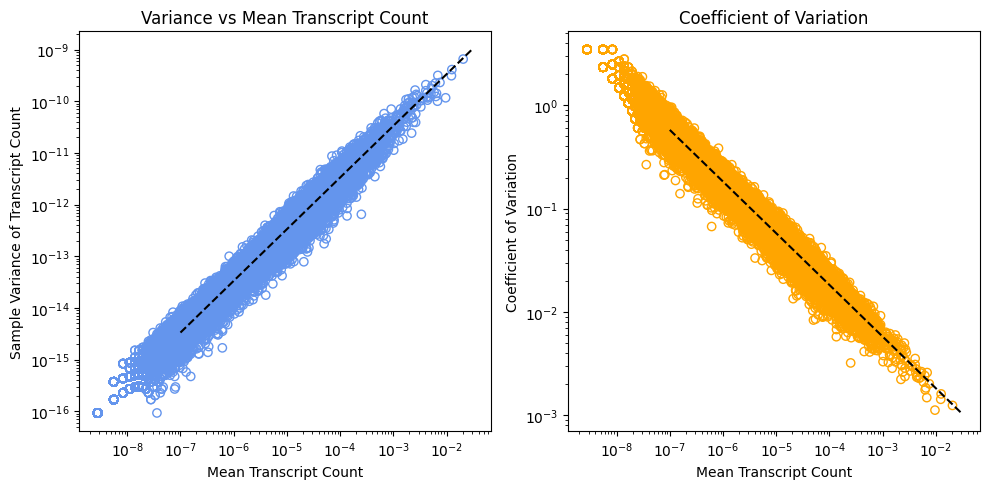

In [24]:
# SOLUTION
# Create the figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sample_counts = pd.DataFrame(sample_counts)
sample_counts_normalized = sample_counts.div(sample_counts.sum(axis=1), axis=0)
sample_counts_normalized

# First subplot
ax1.scatter(sample_counts_normalized.mean(axis = 0), sample_counts_normalized.var(ddof=1, axis = 0), facecolor="none", edgecolor='cornflowerblue')
ax1.plot(freq_values, freq_values/n_reads, c="black", ls="--")
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel("Mean Transcript Count")
ax1.set_ylabel("Sample Variance of Transcript Count")
ax1.set_title("Variance vs Mean Transcript Count")

# Second subplot
ax2.scatter(sample_counts_normalized.mean(axis = 0), sample_counts_normalized.std(ddof=1, axis = 0)/sample_counts_normalized.mean(axis = 0), facecolor="none", edgecolor='orange')
binom_pvals = np.linspace(1, np.max(sample_counts_normalized), 100)
ax2.plot(freq_values, np.sqrt(1/(freq_values*n_reads)), c="black", ls="--")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel("Mean Transcript Count")
ax2.set_ylabel("Coefficient of Variation")
ax2.set_title("Coefficient of Variation")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

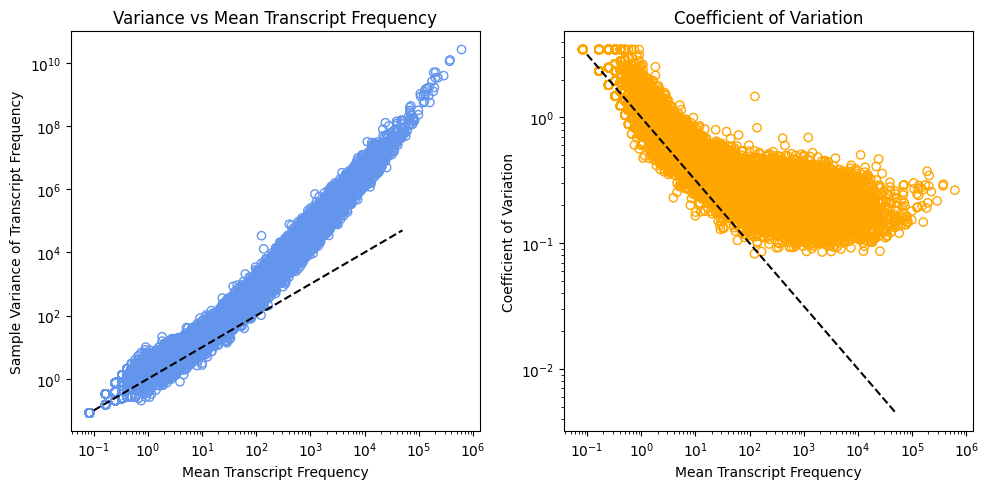

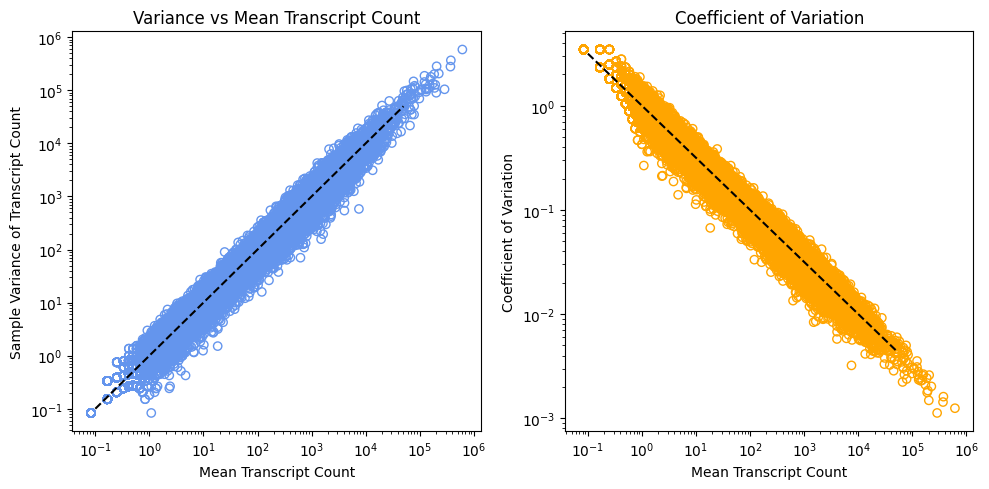

In [25]:
# SOLUTION plots for 1.1-1.4 using counts rather than frequency:

# data plots

mean_values = bulk_data.mean()
var_values = bulk_data.var()

# Create the figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
count_values = np.linspace(1E-1, 5E4, 100)
n_samples = bulk_data.shape[0] #number of samples
n_transcripts = bulk_data.shape[1]
total_reads = bulk_data.values.sum()
n_reads = int(total_reads/n_samples) # number of reads per sample (sequencing depth)

ax1.plot(count_values, count_values, c="black", ls="--")
ax1.scatter(mean_values, var_values, facecolor="none", edgecolor='cornflowerblue')
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel("Mean Transcript Frequency")
ax1.set_ylabel("Sample Variance of Transcript Frequency")
ax1.set_title("Variance vs Mean Transcript Frequency")

# Second subplot
ax2.scatter(mean_values, bulk_data.std(ddof=1)/mean_values, facecolor="none", edgecolor='orange')
ax2.plot(count_values, 1/np.sqrt(count_values), c="black", ls="--")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel("Mean Transcript Frequency")
ax2.set_ylabel("Coefficient of Variation")
ax2.set_title("Coefficient of Variation")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

# simulation plots

# Create the figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sample_counts = pd.DataFrame(sample_counts)
sample_counts_normalized = sample_counts.div(sample_counts.sum(axis=1), axis=0)
sample_counts_normalized

# First subplot
ax1.scatter(sample_counts.mean(axis = 0), sample_counts.var(ddof=1, axis = 0), facecolor="none", edgecolor='cornflowerblue')
ax1.plot(count_values, count_values, c="black", ls="--")
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel("Mean Transcript Count")
ax1.set_ylabel("Sample Variance of Transcript Count")
ax1.set_title("Variance vs Mean Transcript Count")

# Second subplot
ax2.scatter(sample_counts.mean(axis = 0), sample_counts.std(ddof=1, axis = 0)/sample_counts.mean(axis = 0), facecolor="none", edgecolor='orange')
ax2.plot(count_values, 1/np.sqrt(count_values), c="black", ls="--")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel("Mean Transcript Count")
ax2.set_ylabel("Coefficient of Variation")
ax2.set_title("Coefficient of Variation")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

## Pseudobulk analysis

It's possible that there are different sources of noise in single cell RNASeq compared to bulk RNASeq that result in systematic differences between the two methods. Let's check if this is true by comparing scRNASeq data with bulk data from the same condition.

<font color = 'orange'>

<b> Exercise 2 (5 points) </b>

2.1 [3 points] Generate "pseudobulk" data by summing reads across single cell samples. Now, plot the frequency of each gene from the bulk data and the pseudobulk data. Be careful here to make sure that you're only plotting genes that are overlapping in the scRNAseq data and that their names are aligned! What is the correlation between the bulk and pseudobulk data?

2.2 [1 point] Plot the frequencies of each gene for bulk replicates 1 and 2 against each other and calculate the correlation.

2.3 [1 point] Is the correlation between pseudobulk and bulk data comparable to the replicate-to-replicate correlation? Do you think there are systematic differences between bulk and pseudobulk?


<font color = 'lightblue'>

2.1 See code below. The correlation between pseudobulk and bulk data is 0.78

2.2 See code below. The correlation between replicates of bulk data is >0.99.

2.3 While both correlations are relatively high, the correlation between pseudobulk is lower than the replicate-to-replicate correlation, suggesting that there's either more noise in the single-cell data or systematic differences between single-cell and bulk data.


In [ ]:
# import jackson et al data
jackson_data = pd.read_csv("/Users/shailimathur/Documents/GitHub/W25_drylab_prep/data/jackson_data_YPD_proline_Cstarve.tsv", sep='\t', index_col=0)

# took about 15s to load on SM's laptop, probably much longer on other peoples - let's use just a subset?

# pseudobulk analysis

#grab single cell YPD data
YPD_data = jackson_data.loc[jackson_data.Condition == "YPD"].iloc[:, :-5]
YPD_data_sum = YPD_data.sum().sort_index() # sum for pseudobulk
bulk_data_sum = bulk_data.sum().sort_index() # sum bulk data across samples



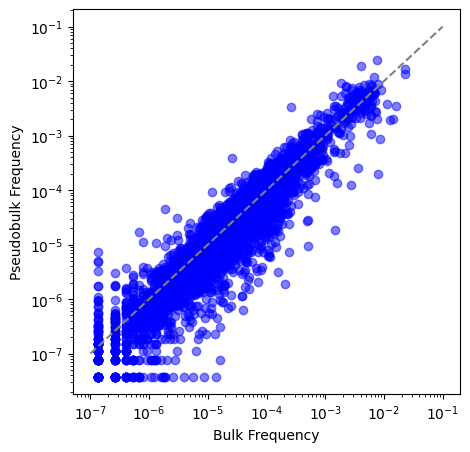

PearsonRResult(statistic=0.7816674327560231, pvalue=0.0)


In [ ]:
# SOLUTION
# align gene names
overlapping_list = bulk_data_sum.index.intersection(YPD_data_sum.index)
bulk_data_sum = bulk_data_sum.loc[overlapping_list]
YPD_data_sum = YPD_data_sum.loc[overlapping_list]

# plot
plt.figure(figsize = (5,5))
plt.plot([1E-7,1E-1], [1E-7, 1E-1], c = "grey", ls = "--")
plt.scatter(bulk_data_sum.values/sum(bulk_data_sum.values), YPD_data_sum.values/sum(YPD_data_sum.values), alpha= 0.5, c = "blue")
plt.xscale('log'); plt.yscale('log')
plt.xlabel("Bulk Frequency")
plt.ylabel("Pseudobulk Frequency")
plt.show()
print(scipy.stats.pearsonr(bulk_data_sum.values/sum(bulk_data_sum.values), YPD_data_sum.values/sum(YPD_data_sum.values)))

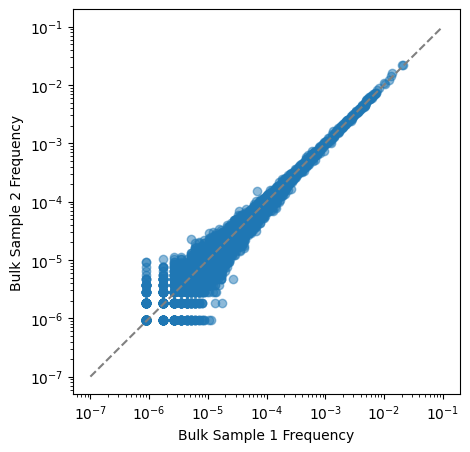

PearsonRResult(statistic=0.9987260668400478, pvalue=0.0)


In [ ]:
# SOLUTION

plt.figure(figsize = (5,5))
plt.plot([1E-7,1E-1], [1E-7, 1E-1], c = "grey", ls = "--")
plt.scatter(bulk_data.loc[0,:]/sum(bulk_data.loc[0,:].values), bulk_data.loc[1,:]/sum(bulk_data.loc[1,:].values), alpha=0.5)
plt.xscale('log'); plt.yscale('log')
plt.xlabel("Bulk Sample 1 Frequency")
plt.ylabel("Bulk Sample 2 Frequency")
plt.show()
print(scipy.stats.pearsonr(bulk_data.loc[0,:]/sum(bulk_data.loc[0,:].values), bulk_data.loc[1,:]/sum(bulk_data.loc[1,:].values)))

## Dimensionality Reduction and Clustering

Let us now consider dimensionality reduction. In class, we discussed principal component analysis (PCA) and Uniform Manifold Approximation and Projection (UMAP). Rooted in linear algebra, PCA determines linear combinations of the original axes that capture the most variance in the data. In other words, it finds a lower-dimensional subspace—like a plane—that best represents the dominant trends in the dataset. PCA is commonly used to get an initial look at high-dimensional biological data, illustrating, for example, differences among analyzed samples. However, PCA is inherently linear while, as we discussed before, biological data is often strongly non-linear. Ideally, we thus have a method that can account for such non-linearities. One approach we discussed in class is UMAP, which uses local manifold approximations and a fuzzy graph representation to produce a low-dimensional embedding that preserves complex nonlinear structures in the data. It is beyond the scope of this class to delve into the analytical details of this method, but in class we provided an intuition for how the algorithm works. UMAP is increasingly used to analyze RNAseq data. Here, you will use both methods, PCA and UMAP, to explore and analyze the RNA-seq data from Jackson et al.

<font color = 'orange'>

<b> Exercise 3 (10 points + 5 Extra Credit) </b>

3.1 [1 points] Look at the code below that performs PCA and UMAP on the single-cell YPD data, plotting the first two reduced dimensions. Do you see any obvious clustering?

3.2 [1 point] The code provided also plots the fraction of variance captured by each PC. Based on this, does it feel safe to make conclusions based only on the top 10 dimensions? Why or why not?

3.3 [4 points] Modify the provided code to generate the PCA and UMAP figures from YPD to analyze the proline data (growth on proline) as detailed below. You'll also find code to cluster the proline data into two groups using K-means. Color points on your graphs by cluster label (hint: you might find cmap helpful here)

3.4 [2 points] Do you see clearer clustering behavior in one of the two conditions (YPD, proline) that you have generated plots for?

3.5 [2 points] Proline is a stressful starvation condition with nitrogen limitation, whereas YPD considered in 3.1 is a rich medium promoting fast growth without stress. What would be a biological reason to expect clearer clustering behavior in one condition rather than another?

3.6 [5 points] (Extra Credit)

(i) Generate data frames with the following:
- PCA on scaled data (as in the example)
- PCA on unscaled data
- UMAP on scaled data (as in the example)
- UMAP on unscaled data
- UMAP on scaled data from PCA on unscaled raw data (using the top 10 components)
- UMAP on unscaled data from PCA on unscaled raw data (using top 10 components)

Generate a PCA/UMAP plot for each of the analyses detailed above with the top two dimensions, colored by the cluster labels.

(ii) Compare the structuring of the data in the PCA plots and the unscaled raw data UMAP with that of the scaled raw data UMAP. In which conditions do you see clusters forming? Why do you think this pattern might be occurring?

(iii) Now compare the UMAP plot generated by using scaled PCA components with the UMAP from the scaled raw data. Does this plot support your idea from 3.2?

<font color = 'lightblue'>

3.1 There's no obvious clustering in the PCA, but there does appear to be some clustering in the UMAP.

3.2 The total variance explained by the first 10 PCs is approximately 0.7 (70%). It seems reasonable to draw some conclusions, but it is worth checking by including all of the data.

3.3 See code below.

3.4 There's clearer clustering in the proline data than the YPD data.

3.5 It makes sense for there to be more clustering in the proline conditon because it is a stressful condition (as opposed to YPD), because there could be heterogeneous cell reaponses to stress as a form of bet-hedging.

3.6 (i) See code below for plots.

(ii) There is fairly clear clustering in all of the plots except for the UMAP on scaled raw data. This is likely because scaling the data treats each of the genes equally by transforming values into Z-scores, so that the mean of each feature is 0 and the variance is 1. If there is a relatively small number of features which captures the variance in the data, these would be overwhelmed by the other features in this case.

(iii) Using the top 10 PCs as input and then scaling for UMAP preserves the clustering in the data, implying that the first 10 PCs capture similar information to all of the data in regards to the clustering behavior of the data.

         PC1        PC2        PC3        PC4        PC5       PC6        PC7  \
0 -52.866611  -0.039900   2.766036   8.138060  -4.035958  7.114051   5.489017   
1 -29.591720  11.171531 -17.366068 -12.993980  19.582137  0.584946  -0.201400   
2 -37.449763  -0.337394  29.195508   0.887943   7.449551  6.991551 -19.738270   
3  36.740330  28.282940  38.681578  -1.164286  15.976092 -7.260955   4.692777   
4 -22.267698 -10.714277 -13.444807 -10.856632  13.925704  0.438263 -11.221570   

         PC8       PC9      PC10  
0  -1.694048  5.199833  1.805737  
1   0.778477 -3.744178  6.843991  
2   0.193132 -0.190465  0.930336  
3  14.095876  3.047595  9.663979  
4   2.395481 -3.018759  6.184430  


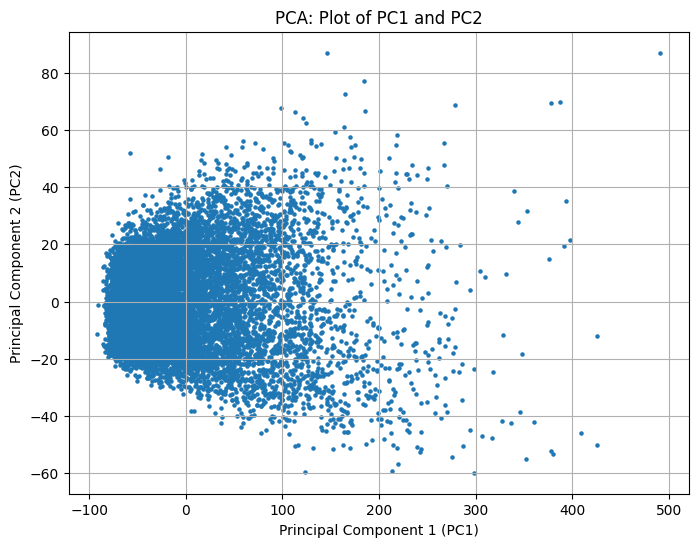

In [ ]:
# Grab YPD counts
YPD_counts = jackson_data.loc[jackson_data.Condition == "YPD"].iloc[:, :-5]

n_PCA_Comps = 10  # Number of PCs to generate

# Perform PCA
pca = PCA(n_components=n_PCA_Comps)
principal_components = pca.fit_transform(YPD_counts)

# Create a DataFrame of the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])

# View the first few rows of the PCA results
print(pca_df.head())

# Plot the points in PC1 and PC2
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], marker='o', s=5)

# Add labels and title
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA: Plot of PC1 and PC2')

plt.grid(True)
plt.show()


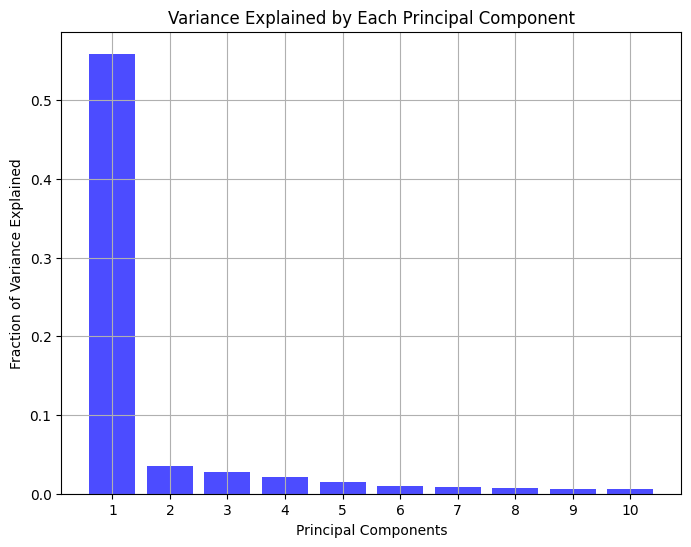

In [ ]:
# Plot the fraction of variance captured by each component
plt.figure(figsize=(8, 6))
plt.bar(range(1, n_PCA_Comps + 1), pca.explained_variance_ratio_, alpha=0.7, color='b')
plt.xlabel('Principal Components')
plt.ylabel('Fraction of Variance Explained')
plt.title('Variance Explained by Each Principal Component')
plt.xticks(range(1, n_PCA_Comps + 1))
plt.grid(True)
plt.show()

In [ ]:
sum(pca.explained_variance_ratio_)

0.6939576827869862

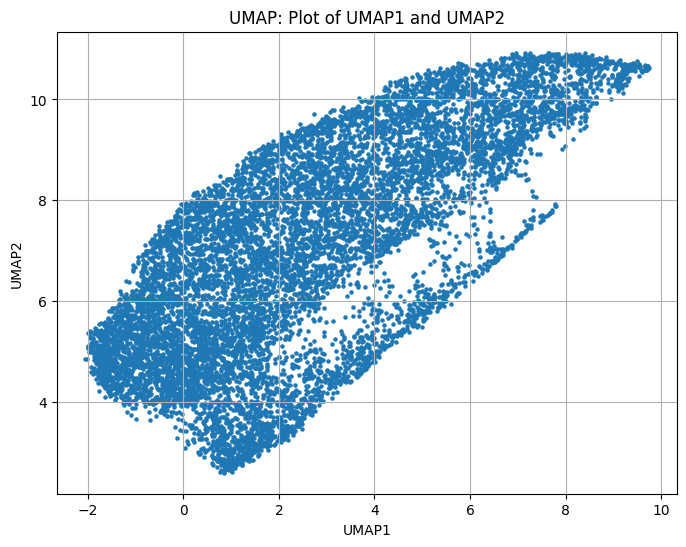

In [ ]:
# UMAP without scaling
# Step 2: Perform UMAP
umap_model = umap.UMAP(n_components=2)

umap_components = umap_model.fit_transform(YPD_counts)

# Step 3: Create a DataFrame of the UMAP results
umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2'])

# Step 4: Plot UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], marker='o', s = 5)

# Add labels and title
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP: Plot of UMAP1 and UMAP2')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
# clustering proline data
proline_counts = jackson_data.loc[jackson_data.Condition == "Proline"].iloc[:, :-5]

# clustering
cluster_labels = cluster.KMeans(n_clusters=2).fit(proline_counts).labels_


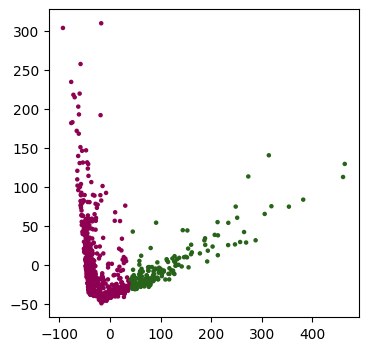

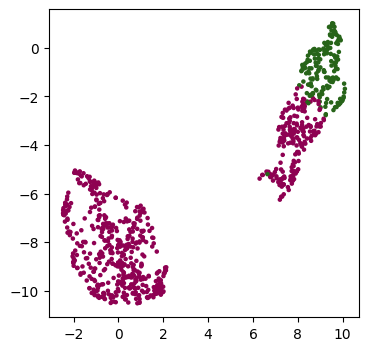

In [ ]:
# SOLUTION 3.3

# PCA on unscaled data
pca_unscaled = PCA(n_components=n_PCA_Comps)
principal_components_unscaled = pca_unscaled.fit_transform(proline_counts)
pca_unscaled_df = pd.DataFrame(data=principal_components_unscaled, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])

plt.figure(figsize=(4,4))
plt.scatter(pca_unscaled_df['PC1'], pca_unscaled_df['PC2'], marker='o', s=5, c=cluster_labels, cmap="PiYG")
plt.show()

# UMAP on unscaled proline
umap_unscaled_proline = umap_model.fit_transform(proline_counts)
umap_unscaled_proline_df = pd.DataFrame(data=umap_unscaled_proline, columns=['UMAP1', 'UMAP2'])

plt.figure(figsize=(4,4))
plt.scatter(umap_unscaled_proline_df['UMAP1'], umap_unscaled_proline_df['UMAP2'], marker='o', s=5, c=cluster_labels, cmap="PiYG")
plt.show()


In [ ]:
# extra credit example code to scale data
# Standardize the data
scaler = StandardScaler()
scaled_YPD_data = scaler.fit_transform(YPD_counts) # you can now feed this into PCA or UMAP instead of YPD_counts

In [ ]:

#SOLUTION extra credit

# Standardize the data
scaler = StandardScaler()
scaled_proline_data = scaler.fit_transform(proline_counts) # you can now feed this into PCA or UMAP

# PCA

# Number of PCA components
n_PCA_Comps = 10

# Perform PCA on unscaled data
pca_unscaled = PCA(n_components=n_PCA_Comps)
principal_components_unscaled = pca_unscaled.fit_transform(proline_counts)

# Perform PCA on scaled data
pca_scaled = PCA(n_components=n_PCA_Comps)
principal_components_scaled = pca_scaled.fit_transform(scaled_proline_data)

# Create DataFrames of the PCA results
pca_unscaled_df = pd.DataFrame(data=principal_components_unscaled, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])
pca_scaled_df = pd.DataFrame(data=principal_components_scaled, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])

# UMAP

#unscaled proline
umap_unscaled_proline = umap_model.fit_transform(proline_counts)
umap_unscaled_proline_df = pd.DataFrame(data=umap_unscaled_proline, columns=['UMAP1', 'UMAP2'])

# scaled proline
scaler = StandardScaler()
umap_scaled_proline = umap_model.fit_transform(scaled_proline_data)
umap_scaled_proline_df = pd.DataFrame(data=umap_scaled_proline, columns=['UMAP1', 'UMAP2'])

# unscaled PCA
umap_unscaled_PCA = umap_model.fit_transform(principal_components_unscaled)
umap_unscaled_PCA_df = pd.DataFrame(data=umap_unscaled_PCA, columns=['UMAP1', 'UMAP2'])

# scaled PCA
scaler = StandardScaler()
scaled_PCA_components = scaler.fit_transform(principal_components_unscaled)
umap_scaled_PCA = umap_model.fit_transform(scaled_PCA_components)
umap_scaled_PCA_df = pd.DataFrame(data=umap_scaled_PCA, columns=['UMAP1', 'UMAP2'])


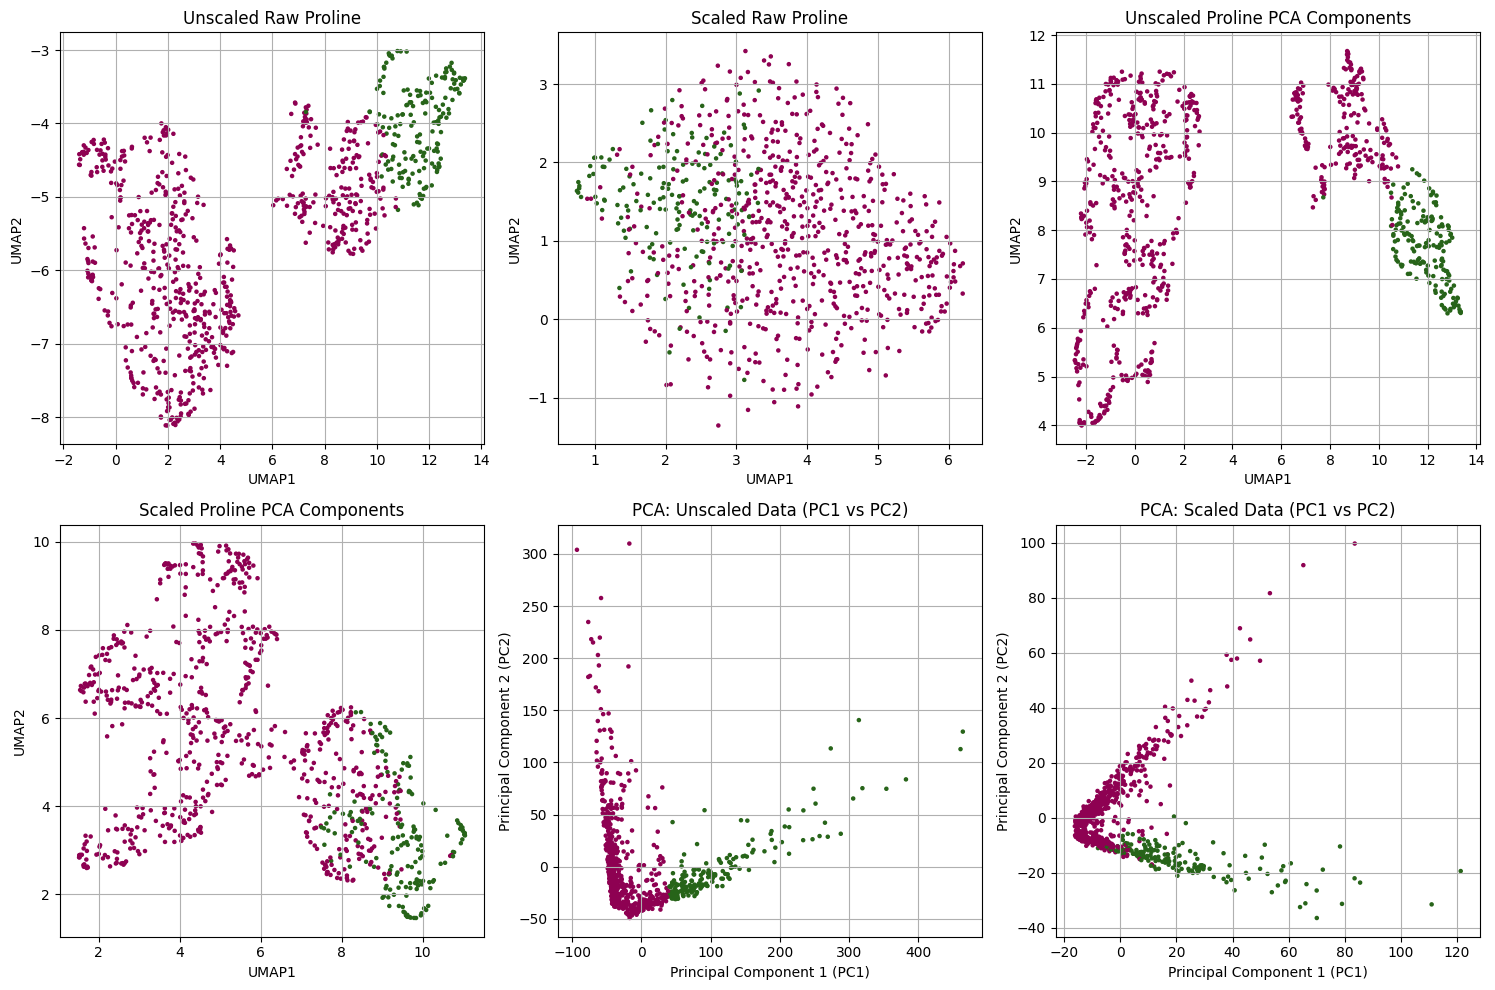

In [ ]:
# Create a single figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

# Data for the UMAP plots (all 4 UMAP datasets)
umap_data = [
    (umap_unscaled_proline_df, "Unscaled Raw Proline"),
    (umap_scaled_proline_df, "Scaled Raw Proline"),
    (umap_unscaled_PCA_df, "Unscaled Proline PCA Components"),
    (umap_scaled_PCA_df, "Scaled Proline PCA Components")
]

# Loop through the axes and UMAP data to plot
for i, ax in enumerate(axes[0, :3].flatten()):  # First row, 3 columns
    df, title = umap_data[i]
    ax.scatter(df['UMAP1'], df['UMAP2'], marker='o', s=5, c=cluster_labels, cmap="PiYG")
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(title)
    ax.grid(True)

# Plot the 4th UMAP plot in the last subplot (bottom-left)
df, title = umap_data[3]  # This is the 4th UMAP dataset
axes[1, 0].scatter(df['UMAP1'], df['UMAP2'], marker='o', s=5, c=cluster_labels, cmap="PiYG")
axes[1, 0].set_xlabel('UMAP1')
axes[1, 0].set_ylabel('UMAP2')
axes[1, 0].set_title(title)
axes[1, 0].grid(True)

# Data for the PCA plots
pca_data = [
    (pca_unscaled_df, "PCA: Unscaled Data (PC1 vs PC2)"),
    (pca_scaled_df, "PCA: Scaled Data (PC1 vs PC2)")
]

# Loop through the axes and PCA data to plot (second row, 2 columns)
for i, ax in enumerate(axes[1, 1:]):  # Second row, 2 columns
    df, title = pca_data[i]
    ax.scatter(df['PC1'], df['PC2'], marker='o', s=5, c=cluster_labels, cmap="PiYG")
    ax.set_xlabel('Principal Component 1 (PC1)')
    ax.set_ylabel('Principal Component 2 (PC2)')
    ax.set_title(title)
    ax.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


## Differential Expresssion

In the previous exercise we fit clusters to the single-cell RNA Seq in proline. In this exercise we'll perform differential expression analysis on cells in the two clusters that emerge. In order to do this, we will use a "pseudobulk" method, where we combine reads from cells that are in the same cluster and the same replicate.

<font color = 'orange'>

<b> Exercise 4 (10 points) </b>

4.1 [2 points] Complete the code below to generate a dataframe "proline_psbulk_data" that has the sum of transcripts for cells in the same cluster and replicate (you might want to use groupby here). Make sure that this dataframe contrains <b> only </b> count data. Now, run the code written below to perform differential expression analysis on the two clusters using PyDESeq2. You do not need to edit this code and should get a dataframe named ```DE_results_df``` with the results of the differential expression analysis.

4.2 [2 points] Make a volcano plot of the unadjusted p-values against the log2-fold change, with vertical lines at -1 and 1 (indicating a change by a factor of 2).

4.3 [2 points] Calculate the Benjamini-Hochberg threshold. You may use the solution to the extra credit in Week 4 if you like. Note that this is equivalent to the padj (adjusted p value) that is provided by PyDESeq2, but here, we'll adjust cutoffs rather than the p-values. Modify your plot from 4.2 to add a horizontal line at the Benjamini-Hochberg cutoff, and color genes marked as significantly differently than the other genes.

4.4 [2 points] In Jackson et al, the authors suggest that these two subpopulations of cells differ in their expression of gene groups. To classiy genes into groups they used a classification from Gasch et al. Import the dataset from Gasch et al (`gene_groups.tsv`). Modify your plot from 4.2 to color all genes grey, and on top of this add a scatter plot of ribosomal genes (group "RP" and "RiBi") and induced environmental stress response ("iESR") genes. What pattern, if any, do you see here?

4.5 [2 points] Finally, you'll find code to generate UMAP plots of cells in rich media (YPD) and starvation (CStarve), with each cell colored by their counts of iESR and ribosomal genes. Edit the code in the first block (indicated by a comment) to add the proline condition to this plotting code. How do you interpret these results in terms of what each subpopulation in the proline environment is doing?


<font color = 'lightblue'>

4.1 see code below

4.2 see code below

4.3 see code below

4.4 see code below. iESR and RP/RiBi genes show opposite patterns; one of the clusters highly expresses RP/RiBi genes and downregulates iESR genes relative to the other cluster.

4.5 see code below. The interpretation of this plot is consistent with the plot above. We see that cells in YPD (rich media) has high experession of RP/RiBi genes and low expresstion of iESR (stress) genes, whereas cells in carbon starvation (CStarve) have the opposite expression patter. One cluster in proline behaves like unstressed cells in YPD, and the other like stressed cells in CStarve.

In [ ]:
# set up to pseudobulk proline_data by replicate and cluster
proline_data = jackson_data.loc[jackson_data.Condition == "Proline"]
proline_data = proline_data.drop(['Genotype', 'Genotype_Group', 'Condition', "tenXBarcode"], axis=1)
proline_data["cluster_label"] = cluster_labels
print(proline_data.shape)


(853, 6831)


In [ ]:

# SOLUTION
proline_psdata_data = proline_data.groupby(["Replicate", "cluster_label"]).sum().reset_index()
rep_cluster_labels = proline_psdata_data.cluster_label
proline_psdata_data = proline_psdata_data.drop(["Replicate", "cluster_label"], axis=1)
proline_psdata_data = proline_psdata_data.loc[:, proline_psdata_data.sum(axis=0) != 0]
proline_psdata_data = proline_psdata_data.loc[:, proline_psdata_data.var(axis=0) != 0]
proline_psdata_data


,YDL248W,YDL244W,YDL243C,YDL240W,YDL239C,YDL238C,YDL237W,YDL236W,YDL235C,YDL234C,...,Q0060,Q0075,Q0085,Q0115,Q0130,X21S_rRNA,Q0160,Q0250,KANMX,NATMX
0,0,0,0,0,0,0,1,2,0,1,...,0,0,0,0,0,0,0,0,29,42
1,0,0,0,0,0,0,2,0,0,1,...,0,0,0,0,0,0,0,0,9,4
2,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,7,2
3,0,0,0,0,0,0,1,2,2,0,...,0,1,0,0,0,0,0,0,33,58
4,0,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,22,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,0,0,0,0,0,0,0,2,0,2,...,0,0,0,0,0,1,0,0,25,22
125,0,0,0,0,2,0,2,0,1,0,...,0,0,0,0,0,0,0,0,28,32
126,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,25,14
127,0,0,0,0,0,0,1,4,1,0,...,0,0,0,0,0,3,0,0,47,83


In [ ]:
# differential expression analysis
# no need to edit this block

# Prepare the count matrix (proline_counts)
count_matrix = proline_psdata_data.values  # Convert to numpy array
genes = proline_psdata_data.columns  # Gene names
samples = proline_psdata_data.index  # Sample names

# Prepare the condition labels (kmeans_labels)
condition_labels = rep_cluster_labels  # Condition labels (0 or 1 from k-means)

# Ensure that condition_labels corresponds to the sample order
if len(condition_labels) != len(samples):
    raise ValueError("Condition labels must match the number of samples.")

# 3. Create the DeseqDataSet object
# Create a metadata dataframe for conditions
metadata = pd.DataFrame({'condition': condition_labels}, index=samples)

# Create the DeseqDataSet using count matrix and metadata
dds = DeseqDataSet(counts=count_matrix, metadata=metadata)


# Initialize inference engine
inference = DefaultInference(n_cpus=8)

# Create the DESeq2 dataset
dds = DeseqDataSet(
    counts=count_matrix,
    metadata=metadata,
)

dds.deseq2()
# Extract results
res = DeseqStats(dds, contrast=["condition",0,1])
res.summary()

# Get the results as a DataFrame
DE_results_df = res.results_df
DE_results_df["gene_name"] = list(proline_psdata_data.columns)
display(DE_results_df.head())

Using None as control genes, passed at DeseqDataSet initialization


/Users/shailimathur/Documents/GitHub/history_dependence/.conda/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/shailimathur/Documents/GitHub/history_dependence/.conda/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 0.84 seconds.

Fitting dispersion trend curve...
... done in 0.15 seconds.

Fitting MAP dispersions...
... done in 1.53 seconds.

Fitting LFCs...
... done in 0.89 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition 0 vs 1
       baseMean  log2FoldChange     lfcSE       stat        pvalue  \
0      0.045552       -0.047151  1.794988  -0.026268  9.790435e-01   
1      0.023351        0.172547  2.346881   0.073522  9.413910e-01   
2      0.072299       -0.143036  1.035672  -0.138110  8.901538e-01   
3      0.056453        0.262442  1.765422   0.148657  8.818246e-01   
4      0.045849        0.080180  1.532232   0.052329  9.582664e-01   
...         ...             ...       ...        ...           ...   
5948   0.453685        1.674737  0.415992   4.025884  5.676172e-05   
5949   0.002482        0.118159  2.973523   0.039737  9.683027e-01   
5950   0.008013        0.123685  2.973408   0.041597  9.668198e-01   
5951  18.915626        0.804071  0.086033   9.346083  9.095415e-21   
5952  25.969301        1.697003  0.126290  13.437332  3.653759e-41   

              padj  
0              NaN  
1              NaN  
2              NaN  
3              NaN  

... done in 0.35 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
0,0.045552,-0.047151,1.794988,-0.026268,0.979044,NaN,YDL248W
1,0.023351,0.172547,2.346881,0.073522,0.941391,NaN,YDL244W
2,0.072299,-0.143036,1.035672,-0.138110,0.890154,NaN,YDL243C
3,0.056453,0.262442,1.765422,0.148657,0.881825,NaN,YDL240W
4,0.045849,0.080180,1.532232,0.052329,0.958266,NaN,YDL239C


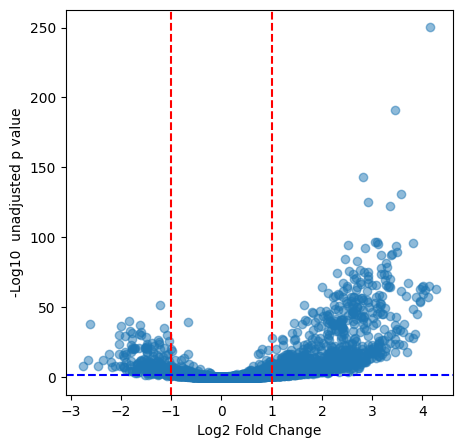

In [ ]:
# SOLUTION
plt.figure(figsize=(5,5))
plt.scatter(DE_results_df.log2FoldChange, -np.log10(DE_results_df.pvalue), alpha = 0.5)


# Add significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--", color="blue")
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--", color="red")

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10  unadjusted p value")

plt.show()


0.012685565283160224


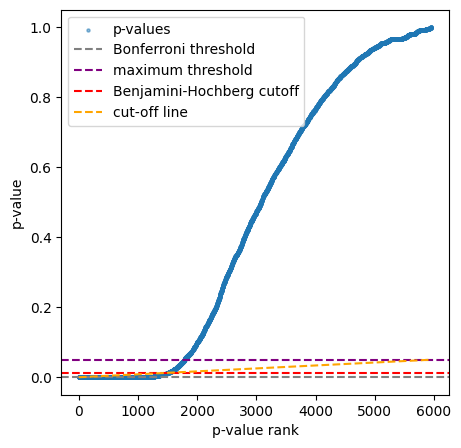

In [ ]:
# SOLUTION
# Benjamini-hochberg correction
# first write code to find the threshold for the cut-off

# list of all the p-values
all_pvals = list(DE_results_df.pvalue.values)
all_pvals.sort() # sort in increasing order
n_tests = DE_results_df.shape[0]
alpha = 0.05
# get the alpha cutoff values be drawing a line between the Bonferroni cutoff (0.08/n_tests) and the original threshold (0.08)
alpha_cutoff = np.arange(0, n_tests)*((alpha - alpha/n_tests))/n_tests + alpha/n_tests

# find the p-values that are below the alpha-cutoff line
n_pvals_below_cutoff = len([x for x in alpha_cutoff - all_pvals if x >= 0])

# as the p-values are aranged in increasing order, we can find the new threshold by looking at the value in index n_pvals_below_cutoff - 1:
BH_pval_threshold = all_pvals[n_pvals_below_cutoff-1]
print(BH_pval_threshold)

# make the figure showing the Benjamini-Hochberg cutoffs
# you don't need to make this figure for full credit; this is just to demonstrate what the code is doing!
plt.figure(figsize=(5,5))
plt.scatter(np.arange(0, n_tests), all_pvals, s = 5, alpha= 0.5, label = "p-values")
plt.axhline(alpha/n_tests, c = "grey", ls = "--", label = "Bonferroni threshold")
plt.axhline(alpha, ls = "--", c = "purple", label = "maximum threshold")
plt.axhline(BH_pval_threshold, ls = "--", c = "red", label = "Benjamini-Hochberg cutoff")
plt.plot([0,n_tests-1], [alpha/n_tests, alpha], ls = "--", c = "orange", label =  "cut-off line")
plt.xlabel("p-value rank")
plt.ylabel("p-value")
plt.legend()
plt.show()

# add the significance calls from the BH cutoff:
DE_results_df["sig_BH"] = np.where((DE_results_df['pvalue'] < BH_pval_threshold), 1, 0)
DE_results_df["p_adj_BH"] = DE_results_df['pvalue'] * alpha/BH_pval_threshold

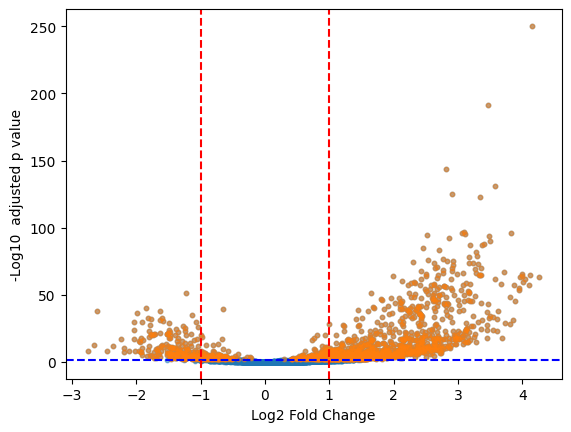

In [ ]:
# SOLUTION
# plt.figure(figsize=(5,5))
plt.scatter(DE_results_df.log2FoldChange, -np.log10(DE_results_df.pvalue), alpha = 0.5, s = 10)
sig_BH = DE_results_df.loc[DE_results_df.sig_BH == 1]
plt.scatter(sig_BH.log2FoldChange, -np.log10(sig_BH.pvalue), alpha = 0.5, s = 10)

# Add significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--", color="blue")
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--", color="red")

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10  adjusted p value")

plt.show()

In [ ]:
#import gene group information
gene_groups = pd.read_csv("/Users/shailimathur/Documents/GitHub/W25_drylab_prep/data/gene_groups.tsv", sep='\t')
gene_groups.head()


,Gene,Group,Source
0,YDR417C,RP,Gasch_2017
1,YDR454C,RP,Gasch_2017
2,YEL026W,RP,Gasch_2017
3,YER025W,RP,Gasch_2017
4,YGL102C,RP,Gasch_2017


Text(0, 0.5, '-Log10  adjusted p value')

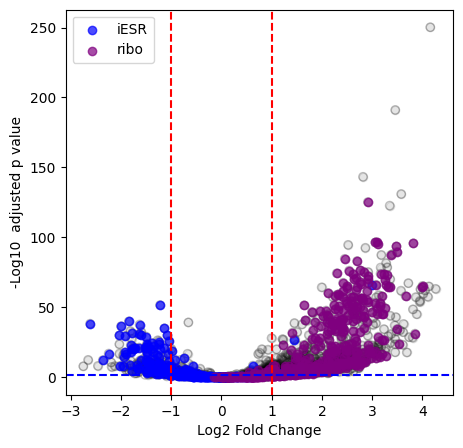

In [ ]:
# SOLUTION

iESR_genes = gene_groups[gene_groups.Group == "iESR"].Gene.values
ribo_genes = gene_groups[gene_groups.Group.isin(["RP", "RiBi"])].Gene.values

plt.figure(figsize=(5,5))
plt.scatter(DE_results_df.log2FoldChange, -np.log10(DE_results_df.pvalue), alpha = 0.5, facecolor = "none", edgecolors="grey")
sig_BH = DE_results_df.loc[DE_results_df.sig_BH == 1]
plt.scatter(sig_BH.log2FoldChange, -np.log10(sig_BH.pvalue), alpha = 0.1, c = "black")

iESR_results = DE_results_df.loc[DE_results_df.gene_name.isin(iESR_genes)]
plt.scatter(iESR_results.log2FoldChange, -np.log10(iESR_results.pvalue), alpha = 0.7, c = "blue", label = "iESR")

RP_results = DE_results_df.loc[DE_results_df.gene_name.isin(ribo_genes)]
plt.scatter(RP_results.log2FoldChange, -np.log10(RP_results.pvalue), alpha = 0.7, c = "purple", label = "ribo")

plt.legend()

# Add significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--", color="blue")
plt.axvline(1, linestyle="--", color="red")
plt.axvline(-1, linestyle="--", color="red")

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10  adjusted p value")


In [ ]:
# code for 4.6: edit this block

# we already have YPD_counts and proline_counts
CStarve_counts = jackson_data.loc[jackson_data.Condition == "CStarve"].iloc[:, :-5]

# Create a list of counts data
counts_by_env = [YPD_counts, CStarve_counts] # EDIT HERE TO ADD PROLINE
counts_by_env = [YPD_counts, CStarve_counts, proline_counts] # SOLUTION
UMAP_df_list = []

# Generate UMAP projections for each of the counts data
for counts_df in counts_by_env:
    umap_projection = umap_model.fit_transform(counts_df)
    umap_projection_df = pd.DataFrame(data=umap_projection, columns=['UMAP1', 'UMAP2'])
    UMAP_df_list.append(umap_projection_df)


# Ensure that the columns in the list exist in the DataFrame
iESR_columns = [col for col in iESR_genes if col in jackson_data.columns]
ribo_columns = [col for col in ribo_genes if col in jackson_data.columns]


/var/folders/gp/3sshrqs52zd8gw165f_7y35w0000gp/T/ipykernel_33943/349337490.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


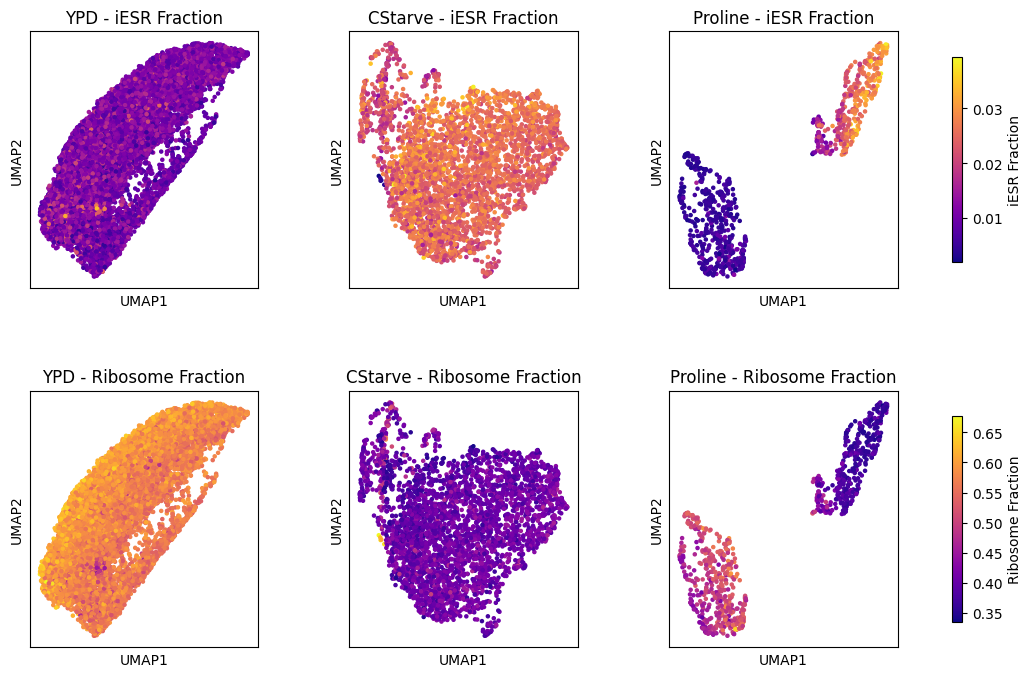

In [ ]:
# code for 4.6 (no need to edit this block; just look at the figure it generates)

# Create a figure with subplots (2 rows, len(counts_by_env) columns)
fig = plt.figure(figsize=(14, 8))  # Adjust figsize as needed
gs = fig.add_gridspec(2, len(counts_by_env), height_ratios=[1, 1], width_ratios=np.ones(len(counts_by_env)), hspace=0.4, wspace=0.4)

# Create axes for the top and bottom row
axes_top = [fig.add_subplot(gs[0, i]) for i in range(len(counts_by_env))]
axes_bottom = [fig.add_subplot(gs[1, i]) for i in range(len(counts_by_env))]

# Environment labels
env_labels = ["YPD", "CStarve", "Proline"]

# Plot UMAP in the top row with iESR fraction
scatters = []  # To hold scatter plot handles for the colorbar
for i, ax in enumerate(axes_top):  # Top row
    umap_df = UMAP_df_list[i]

    # Get iESR gene counts and compute iESR fraction
    iESRcounts_df = counts_by_env[i][iESR_columns]
    iESR_fraction = iESRcounts_df.sum(axis=1).values / counts_by_env[i].sum(axis=1).values

    # Plot UMAP with iESR fraction as color
    scat = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], marker='o', s=5, c=iESR_fraction, cmap="plasma")
    scatters.append(scat)  # Save the scatter handle for the colorbar
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(f"{env_labels[i]} - iESR Fraction")
    ax.set_xticks([]); ax.set_yticks([])


# Add a shared colorbar for the top row (iESR fraction)
fig.colorbar(scatters[0], ax=axes_top, orientation='vertical', label='iESR Fraction', shrink=0.8)

# Plot UMAP in the bottom row with ribosome fraction
scatters = []  # To hold scatter plot handles for the colorbar
for i, ax in enumerate(axes_bottom):  # Bottom row
    umap_df = UMAP_df_list[i]

    # Get ribosome gene counts and compute ribosome fraction
    ribocounts_df = counts_by_env[i][ribo_columns]
    ribo_fraction = ribocounts_df.sum(axis=1).values / counts_by_env[i].sum(axis=1).values

    # Plot UMAP with ribosome fraction as color
    scat = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], marker='o', s=5, c=ribo_fraction, cmap="plasma")
    scatters.append(scat)  # Save the scatter handle for the colorbar
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(f"{env_labels[i]} - Ribosome Fraction")
    ax.set_xticks([]); ax.set_yticks([])

# Add a shared colorbar for the bottom row (ribosome fraction)
fig.colorbar(scatters[0], ax=axes_bottom, orientation='vertical', label='Ribosome Fraction', shrink=0.8)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
